## Time-series modeling 
We create a time series model for the Land-Ocean Temperature Index (LOTI). 
We evaluate different configurations for a SARIMAX (seasonal autoregressive integrated moving average) model using grid search, with mean squared error as a performance metric.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

sns.set()
sns.set_context('notebook', font_scale=1.2)

In [2]:
# wrapper for statsmodels SARIMAX model to make it compatible with the scikit-learn API
class SARIMAXWrapper(BaseEstimator, RegressorMixin):
    """Sklearn wrapper for statsmodels SARIMAX models"""
    def __init__(self, 
                 order=(1, 0, 0), 
                 seasonal_order=(0, 0, 0, 0), 
                 trend=None, 
                 measurement_error=False, 
                 time_varying_regression=False, 
                 mle_regression=True, 
                 simple_differencing=False, 
                 enforce_stationarity=True, 
                 enforce_invertibility=True, 
                 hamilton_representation=False, 
                 concentrate_scale=False,
                 freq=None):
        self.SARIMAX = sm.tsa.SARIMAX
        self.order = order
        self.seasonal_order = seasonal_order
        self.trend = trend
        self.measurement_error = measurement_error
        self.enforce_stationarity = enforce_stationarity
        self.enforce_invertibility = enforce_invertibility
        self.freq = freq
        
    def fit(self, X, y=None):
        self.model_ = self.SARIMAX(endog=X,  
                                   order=self.order, 
                                   seasonal_order=self.seasonal_order,
                                   trend=self.trend,
                                   measurement_error=self.measurement_error,
                                   enforce_stationarity=self.enforce_stationarity,
                                   enforce_invertibility=self.enforce_invertibility,
                                   freq=self.freq)
        try:
            self.results_ = self.model_.fit()
        except ValueError as error:
            print(self.order, error)
    
    def predict(self, X):
        return self.results_.forecast(len(X))

In [3]:
def aic_scorer(estimator, X, y):
    """Get the AIC from a statsmodels model.
    Sklearn style scorer function.
    """
    estimator.fit(X)
    aic = estimator.results_.aic

    return aic

In [4]:
monthly_deviations = pd.read_csv('../data/NASA_GISS_LOTI_long_format.csv', 
                                 index_col='Date', 
                                 parse_dates=['Date'])

In [5]:
# take deviations from mean up to (and including) 2019-01
global_deviations = monthly_deviations['global'][:'2019-01']
northern_deviations = monthly_deviations['northern'][:'2019-01']

There is a clear upward trend and some seasonality in both time-series, thus they are most likely not stationary.

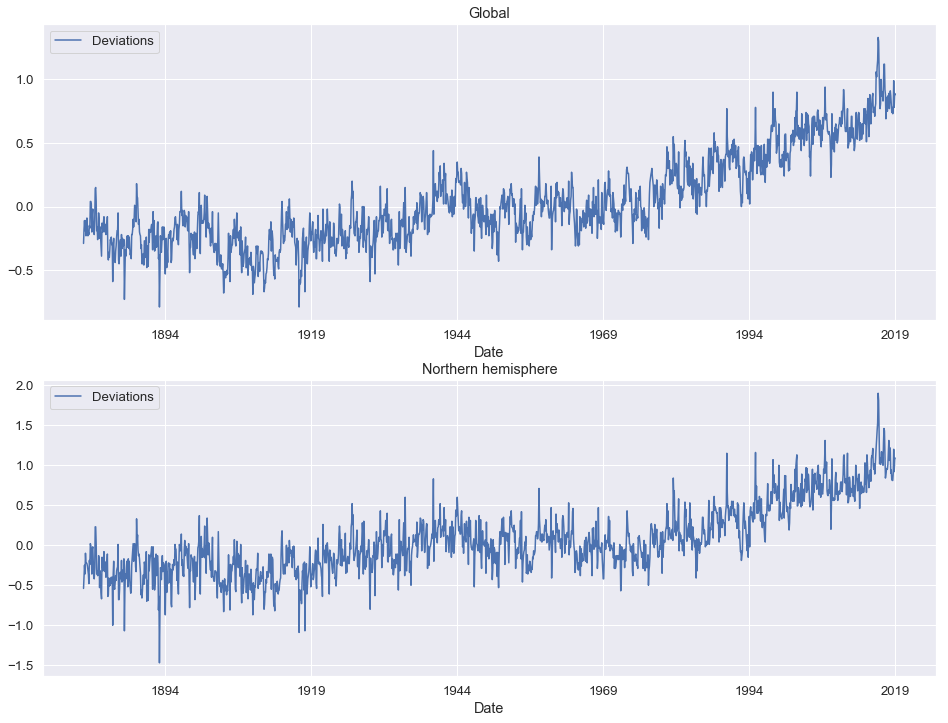

In [60]:
# plot time series
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 12))

global_deviations.plot(ax=ax1, title='Global', label='Deviations')
northern_deviations.plot(ax=ax2, title='Northern hemisphere', label='Deviations')
_ = ax1.legend()
_ = ax2.legend()

### Time series modeling

In [7]:
# split data set into training and validation sets
# we leave the last 12 months for validation
n_test = 12
n_train = global_deviations.shape[0] - n_test

gld_train = global_deviations.iloc[:n_train]
gld_test = global_deviations.iloc[n_train:]

nhd_train = northern_deviations.iloc[:n_train]
nhd_test = northern_deviations.iloc[n_train:]

We test for a unit root using the Augmented Dickey-Fuller (ADF) test. The null hypothesis is that the time-series has a unit root, which implies that it is non-stationary. We allow for a constant and linear term in the regression model, the maximum number of lags is chosen using the Akaike information criterion. The test is performed at significance level $\alpha = 0.01$.

The null hypothesis can not be rejected for either time-series.

In [8]:
print("Augmented Dickey-Fuller test", 
      "Global: p-value = {:.6f}".format(sm.tsa.adfuller(gld_train, regression='ct', autolag='AIC')[1]),
      "Northern: p-value = {:.6f}".format(sm.tsa.adfuller(nhd_train, regression='ct', autolag='AIC')[1]), sep='\n')

Augmented Dickey-Fuller test
Global: p-value = 0.023917
Northern: p-value = 0.102194


The previous plots and the results form the ADF test suggests that the series are not stationary.
We take the first differences to try to make the series stationary.

In [9]:
# calculate first differences and discard first observation (which is NaN after differencing)
gld_train_diff = gld_train.diff(1)[1:]
nhd_train_diff = nhd_train.diff(1)[1:]

The plot of the differenced time-series looks much more closer to a stationary process. Thus it seems reasonable to use first (or higher) order differences in the model. In the ADF test we can also reject the null hypothesis of an unit root.

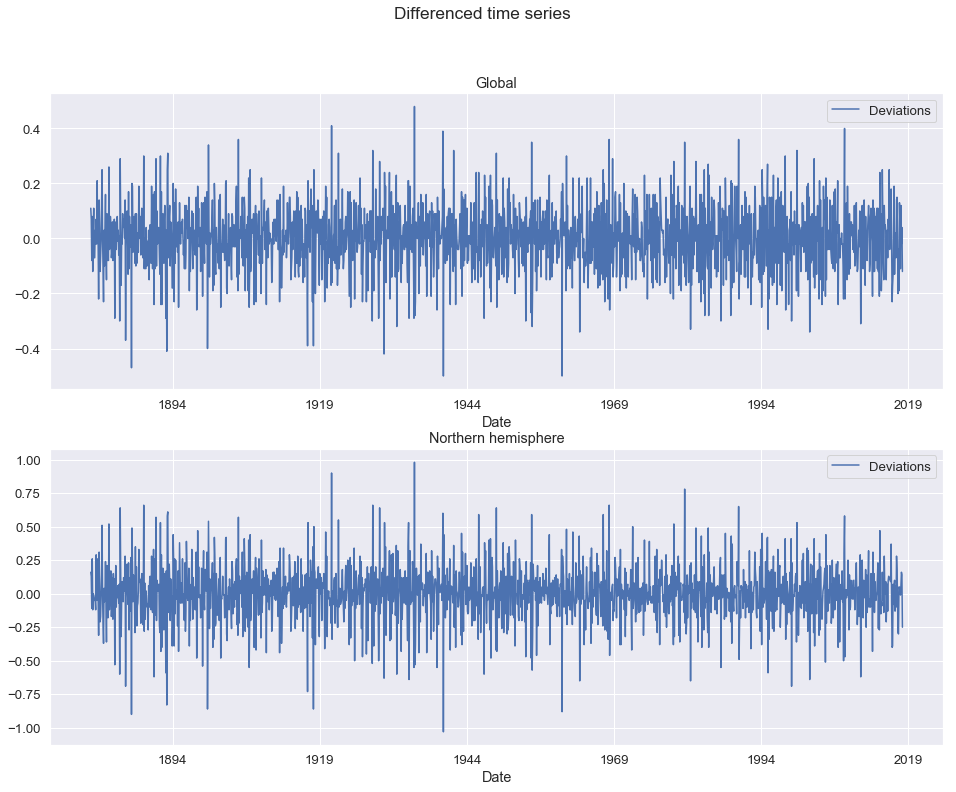

In [61]:
# plot differenced time series
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16, 12))

gld_train_diff.plot(ax=ax1, title='Global', label='Deviations')
nhd_train_diff.plot(ax=ax2, title='Northern hemisphere', label='Deviations')
ax1.legend()
ax2.legend()
_ = plt.suptitle('Differenced time series')

In [11]:
print("Augmented Dickey-Fuller test", 
      "Global: p-value = {:.6f}".format(sm.tsa.adfuller(gld_train_diff, regression='ct', autolag='AIC')[1]),
      "Northern: p-value = {:.6f}".format(sm.tsa.adfuller(nhd_train_diff, regression='ct', autolag='AIC')[1]), sep='\n')

Augmented Dickey-Fuller test
Global: p-value = 0.000000
Northern: p-value = 0.000000


The autocorrelation function (ACF) and partial autocorrelation function (PACF) are calculated and plotted below, to get and idea of what order the model parameters could be.

For the Global deviations time-series:
Since the coefficients in the PACF seems to die out after the $6$:th lag, we choose to use 6 as the upper limit for the auto-regressive (AR) order $p$. The ACF suggests a moving average (MA) order of $1$. We attribute "significant" coefficients at higher lags to random variations in the data.

For the Northern hemisphere deviations time-series:
The PACF suggests a maximum AR order of $11$, and the ACF a maximum MA order of $1$.

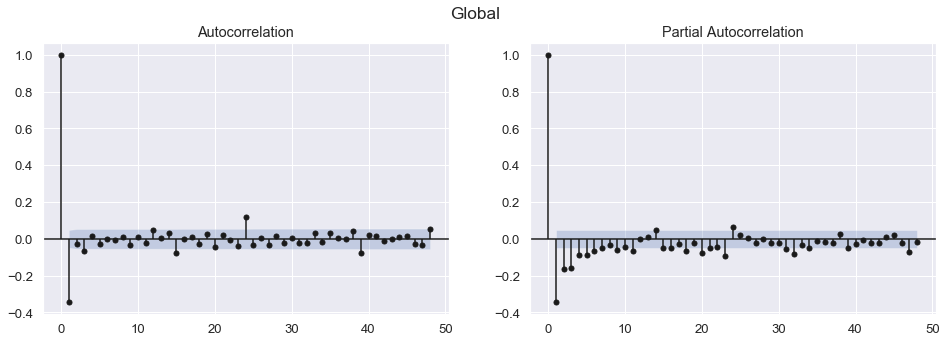

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

nlags = 48

_ = plot_acf(gld_train_diff, lags=nlags, color='k', ax=ax1)
_ = plot_pacf(gld_train_diff, lags=nlags, color='k', ax=ax2)
_ = plt.suptitle('Global')

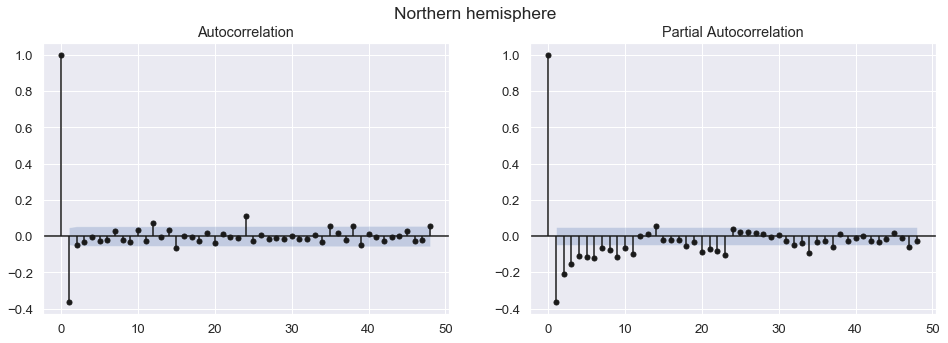

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5))

_ = plot_acf(nhd_train_diff, lags=nlags, color='k', ax=ax1)
_ = plot_pacf(nhd_train_diff, lags=nlags, color='k', ax=ax2)
_ = plt.suptitle('Northern hemisphere')

Using the observations from the ACF and PACF we create the possible configurations for our model.
The a grid search is performed over the different configurations. The models are cross-validated using time series cross-validation which preserves the order relations of the data so that the model is always trained on historical data and tested on more recent "unseen" data.

In [14]:
# AR order
max_order_p = 6
# Differencing order
max_order_i = 1
# MA order
max_order_q = 1

p_orders = range(1, max_order_p + 1)
i_orders = range(1, max_order_i + 1)
q_orders = range(1, max_order_q + 1)

model_orders = list(product(p_orders, i_orders, q_orders))
model_orders

[(1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (6, 1, 1)]

In [70]:
model = SARIMAXWrapper(freq='MS')

# we keep the seasonal orders at a fixed configuration. 
# The last parameter m = 12 indicates number of time steps for a single seasonal period.
# We assume that one season is a year (12 months)

grid = GridSearchCV(model,
                    param_grid={
                        'order': model_orders,
                        'seasonal_order': [(1, 1, 1, 12),],
                        'trend': ['ct',],
                    },
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=2), 
                    n_jobs=1)

grid.fit(gld_train, gld_train)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\fredrik.fagerholm\A

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
       error_score='raise',
       estimator=SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(1, 0, 0),
        seasonal_order=(0, 0, 0, 0), simple_differencing=None,
        time_varying_regression=None, trend=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'order': [(1, 1, 1), (2, 1, 1), (3, 1, 1), (4, 1, 1), (5, 1, 1), (6, 1, 1), (7, 1, 1), (8, 1, 1), (9, 1, 1), (10, 1, 1), (11, 1, 1)], 'seasonal_order': [(1, 1, 1, 12)], 'trend': ['ct']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [ ]:
grid.best_estimator_

In [29]:
print("Best model found through grid search:")
display(grid.best_estimator_)
print("MSE of best model: {:.4f}".format(- grid.best_score_))

Best model found through grid search:


SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(4, 1, 1),
        seasonal_order=(1, 1, 1, 12), simple_differencing=None,
        time_varying_regression=None, trend=None)

Negative MSE of best model: -0.1284


We now refit the model with the best parameter configuration using all of the training data.

In [33]:
gld_model = sm.tsa.SARIMAX(gld_train,
                           order=grid.best_estimator_.order, 
                           seasonal_order=grid.best_estimator_.seasonal_order)
gld_model_fit = gld_model.fit(disp=0)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [34]:
display(gld_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             global   No. Observations:                 1657
Model:             SARIMAX(4, 1, 1)x(1, 1, 1, 12)   Log Likelihood                1288.919
Date:                            Tue, 26 Feb 2019   AIC                          -2561.838
Time:                                    17:37:53   BIC                          -2518.599
Sample:                                01-01-1880   HQIC                         -2545.804
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4772      0.027     17.586      0.000       0.424       0.530
ar.L2          0.1165      0.027      4.321      0.000       0.064       0.169
ar.L3          0.0028      0.028      0.098      0.922      -0.053       0.058
ar.L4          0.1149      0.030      3.830      0.000       0.056       0.174
ma.L1         -0.9527      0.016    -57.841      0.000      -0.985      -0.920
ar.S.L12       0.0117      0.023      0.518      0.605      -0.033       0.056
ma.S.L12      -0.9521      0.008   -114.599      0.000      -0.968      -0.936
sigma2         0.0118      0.000     34.298      0.000       0.011       0.012
===================================================================================
Ljung-Box (Q):                       61.09   Jarque-Bera (JB):                44.13
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.00
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check adequacy of the model by creating a QQ-plot and kernerl density plot for the residuals.
Residuals seems to be close to normally distributed, although the QQ-plot indicates that the tails are somewhat fatter than would be typical for normally distributed values.

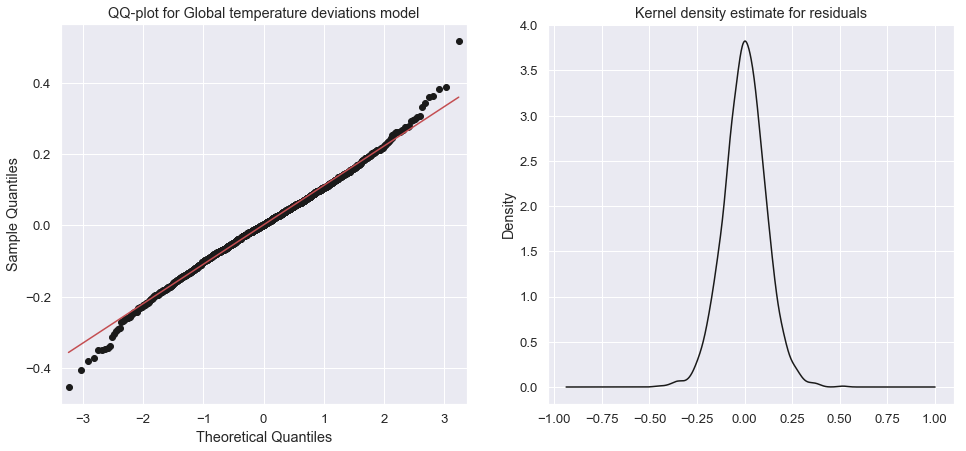

In [64]:
gld_model_resid = pd.Series(gld_model_fit.resid)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
_ = sm.qqplot(gld_model_resid, line='s', color='k', ax=ax1)
_ = ax1.set_title('QQ-plot for Global temperature deviations model')

gld_model_resid.plot(kind='kde', ax=ax2, color='k', title='Kernel density estimate for residuals')

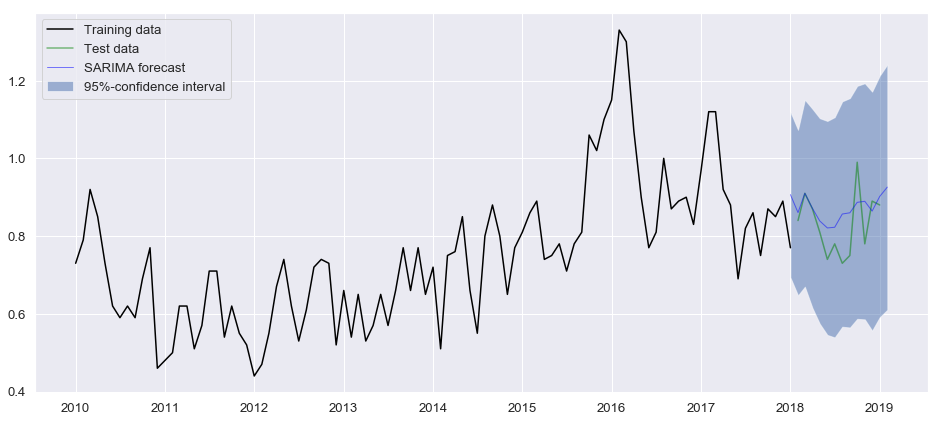

In [66]:
pred_res = gld_model_fit.get_prediction(start='2018-01-01', end='2019-02-01', 
                                        full_results=True, alpha=0.05)

pred_means = pred_res.predicted_mean

# alpha = 0.05 => 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot('111')

# actual data
ax.plot(gld_train['2010':], color="black", label='Training data')
ax.plot(gld_test, color="green", alpha=0.5, label='Test data')

# means
ax.plot(pred_means, lw=1, color="blue", alpha=0.5, label='SARIMA forecast')
ax.fill_between(pred_means.index, pred_cis.iloc[:, 0], pred_cis.iloc[:, 1], alpha=0.5, label='95%-confidence interval')
ax.legend(loc='upper left')
plt.draw()

In [49]:
# AR order
max_order_p = 11
# Differencing order
max_order_i = 1
# MA order
max_order_q = 1

p_orders = range(1, max_order_p + 1)
i_orders = range(1, max_order_i + 1)
q_orders = range(1, max_order_q + 1)

model_orders = list(product(p_orders, i_orders, q_orders))

[(1, 1, 1),
 (2, 1, 1),
 (3, 1, 1),
 (4, 1, 1),
 (5, 1, 1),
 (6, 1, 1),
 (7, 1, 1),
 (8, 1, 1),
 (9, 1, 1),
 (10, 1, 1),
 (11, 1, 1)]

In [69]:
model = SARIMAXWrapper(freq='MS')

grid = GridSearchCV(model, 
                    param_grid={
                        'order': model_orders,
                        'seasonal_order': [(1, 1, 1, 12),],
                        'trend': ['ct',],
                    },
                    scoring='neg_mean_squared_error', 
                    cv=TimeSeriesSplit(n_splits=2), 
                    n_jobs=1)

grid.fit(nhd_train, nhd_train)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


KeyboardInterrupt: 

In [43]:
print("Best model found through grid search:")
display(grid.best_estimator_)
print("MSE of best model: {:.4f}".format(- grid.best_score_))

Best model found through grid search:


SARIMAXWrapper(concentrate_scale=None, enforce_invertibility=True,
        enforce_stationarity=True, freq='MS', hamilton_representation=None,
        measurement_error=False, mle_regression=None, order=(5, 1, 1),
        seasonal_order=(1, 1, 1, 12), simple_differencing=None,
        time_varying_regression=None, trend=None)

Negative MSE of best model: -0.2362


In [42]:
nhd_model = sm.tsa.SARIMAX(nhd_train, 
                           order=grid.best_estimator_.order, 
                           seasonal_order=grid.best_estimator_.seasonal_order)
nhd_model_fit = nhd_model.fit(disp=0)

C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\fredrik.fagerholm\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [44]:
display(nhd_model_fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                           northern   No. Observations:                 1657
Model:             SARIMAX(5, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 438.566
Date:                            Tue, 26 Feb 2019   AIC                           -859.132
Time:                                    18:25:36   BIC                           -810.488
Sample:                                01-01-1880   HQIC                          -841.094
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3820      0.022     17.589      0.000       0.339       0.425
ar.L2          0.1262      0.025      5.082      0.000       0.078       0.175
ar.L3          0.0652      0.028      2.325      0.020       0.010       0.120
ar.L4          0.0488      0.032      1.504      0.132      -0.015       0.112
ar.L5          0.0260      0.031      0.845      0.398      -0.034       0.086
ma.L1         -0.9796      0.007   -132.442      0.000      -0.994      -0.965
ar.S.L12       0.0294      0.021      1.406      0.160      -0.012       0.070
ma.S.L12      -0.9426      0.009   -110.825      0.000      -0.959      -0.926
sigma2         0.0337      0.001     38.662      0.000       0.032       0.035
===================================================================================
Ljung-Box (Q):                       52.15   Jarque-Bera (JB):               197.42
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check adequacy of the model by creating a QQ-plot and kernerl density plot for the residuals.

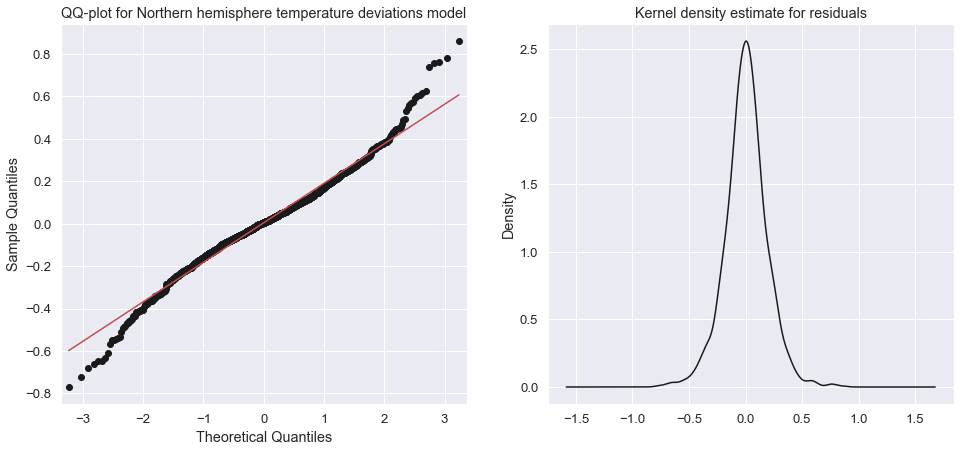

In [67]:
nhd_model_resid = pd.Series(nhd_model_fit.resid)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
_ = sm.qqplot(nhd_model_resid, line='s', color='k', ax=ax1)
_ = ax1.set_title('QQ-plot for Northern hemisphere temperature deviations model')
_ = nhd_model_resid.plot(kind='kde', ax=ax2, color='k', title='Kernel density estimate for residuals')

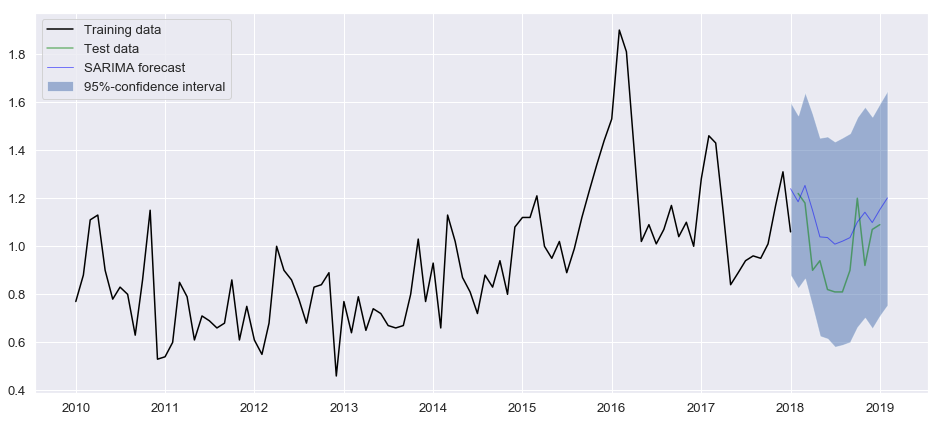

In [68]:
# plot forecast fit 95% CI and compare to actual test data
pred_res = nhd_model_fit.get_prediction(start='2018-01-01', end='2019-02-01', 
                                        full_results=True, alpha=0.05)

pred_means = pred_res.predicted_mean

# alpha = 0.05 => 95% CI
pred_cis = pred_res.conf_int(alpha=0.05)

fig = plt.figure(figsize=(16, 7))
ax = fig.add_subplot('111')

# plot training data from 2010 and forward
ax.plot(nhd_train['2010':], color="black", label='Training data')
# plot test data
ax.plot(nhd_test, color="green", alpha=0.5, label='Test data')

# means
ax.plot(pred_means, lw=1, color="blue", alpha=0.5, label='SARIMA forecast')
ax.fill_between(pred_means.index, pred_cis.iloc[:, 0], pred_cis.iloc[:, 1], alpha=0.5, label='95%-confidence interval')
ax.legend(loc='upper left')
plt.draw()